In [1]:
import torch

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

### Load Model + Probing Dataset

Loading contents from file...


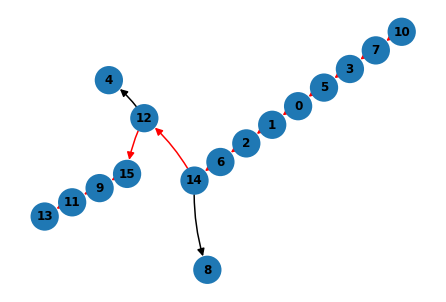

In [2]:
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

In [3]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model_legacy.pt"):
    model.load_state_dict(torch.load("model_legacy.pt"))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), "model_legacy.pt")

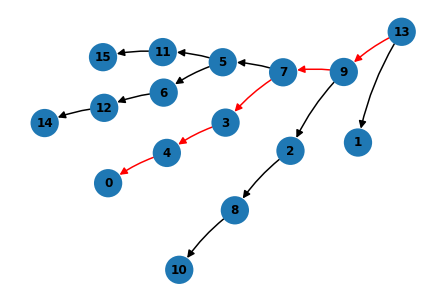

In [4]:
pred = generate_example(16, 0, order="backward", path_length=5)
if is_model_correct(model, dataset, pred):
    parse_example(pred)
cache = get_example_cache(pred, model, dataset)

In [5]:
act_names = ["blocks.1.ln2.hook_normalized", "blocks.2.ln2.hook_normalized", "blocks.3.ln2.hook_normalized", "blocks.4.ln2.hook_normalized", "blocks.5.ln2.hook_normalized", "ln_final.hook_normalized"]
model.reset_hooks()

if not os.path.exists("activations.pt"):
    print("Generating activations...")
    
    acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=32_000,
        path_length=7,
        order="backward"
    )

    test_acts, test_graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=8_000,
        path_length=7,
        order="backward"
    )
    
    torch.save( (acts, graphs, test_acts, test_graphs) , "activations.pt")
else:
    acts, graphs, test_acts, test_graphs = torch.load("activations.pt")


In [6]:
def extract_transposed_adj_matrix(example_str, power=1):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    for edge in edgelist:
        if edge in path_edges:
            color = "red"
        else:
            color = "black"
        G.add_edge(edge[0], edge[1], color=color)
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    adjacency = adjacency_matrix_sparse.toarray().T
    if power is not None:
        ## Change all leaf nodes to self-loops
        row_sums = np.sum(adjacency, axis=1)
        for i in range(len(row_sums)):
            if row_sums[i] == 0:
                adjacency[i, i] = 1
        # Exponentiate matrix
        return np.linalg.matrix_power(adjacency, power)
    else:
        return adjacency

In [7]:


def return_probing_dataset(acts, graphs):
    X = {key: [] for key in acts.keys()}
    y = []
    for gidx, graph in enumerate(graphs):
        # Get output labels
        tokens = dataset.tokenize(graph)[:-1]
        start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",") + 1
        # Find neighboring nodes for each pos in edgelist
        path = [int(x.replace(">", "")) for x in labels[start_idx-1:end_idx-1]]
        path_arr = np.zeros((16,))
        path_arr[path] = 1.
        y.append(path_arr)
        # Iterate over all layers residual streams
        for key in X.keys():
            streams = acts[key][gidx][0, start_idx-1:start_idx]
            X[key].append(streams)
    # Convert everything to np arrays
    for key in X.keys():
        X[key] = torch.cat(X[key], dim=0).detach().cpu().numpy()
    y = np.array(y)
    return X, y


dataX, y = return_probing_dataset(acts, graphs)
dataXTest, y_test = return_probing_dataset(test_acts, test_graphs)

print(dataX["blocks.5.ln2.hook_normalized"].shape)
print(y.shape)

(31443, 128)
(31443, 16)


In [8]:
label = "blocks.5.ln2.hook_normalized"
X = dataX[label]
X_test = dataXTest[label]

### Nonlinear Probing

In [18]:

probe = NonlinearMultiClsProbe(max_iter=200, verbose=True)
probe.fit(X, y.astype(np.float32))
print(probe.score(X, y))

Epoch 0 - Training Loss: 8.5072 - Validation Accuracy: 0.72
Epoch 1 - Training Loss: 6.2851 - Validation Accuracy: 0.81
Epoch 2 - Training Loss: 4.8299 - Validation Accuracy: 0.86
Epoch 3 - Training Loss: 3.9568 - Validation Accuracy: 0.88
Epoch 4 - Training Loss: 3.4122 - Validation Accuracy: 0.90
Epoch 5 - Training Loss: 3.0503 - Validation Accuracy: 0.91
Epoch 6 - Training Loss: 2.7872 - Validation Accuracy: 0.92
Epoch 7 - Training Loss: 2.5935 - Validation Accuracy: 0.92
Epoch 8 - Training Loss: 2.4350 - Validation Accuracy: 0.93
Epoch 9 - Training Loss: 2.3101 - Validation Accuracy: 0.93
Epoch 10 - Training Loss: 2.2049 - Validation Accuracy: 0.93
Epoch 11 - Training Loss: 2.1165 - Validation Accuracy: 0.93
Epoch 12 - Training Loss: 2.0414 - Validation Accuracy: 0.94
Epoch 13 - Training Loss: 1.9753 - Validation Accuracy: 0.94
Epoch 14 - Training Loss: 1.9177 - Validation Accuracy: 0.94
Epoch 15 - Training Loss: 1.8680 - Validation Accuracy: 0.94
Epoch 16 - Training Loss: 1.8220 -

In [21]:
answers = (probe.predict(X_test) > 0.5)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

Accuracy: 98.19%
Precision: 99.35%
Recall: 97.01%


In [ ]:
for test_example_idx in range(10):

    correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
    parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
    plt.show()

### Sparse Coding + Linear Probing

In [12]:

coder = SparseCoder(4096, max_iter=5_000, batch_size=8192, l1_coef=0.001, learning_rate_init=3e-4, verbose=True)
coder.fit(X)

Epoch 0 - Training Total Loss: 15.9926 - Validation Reconstruction Loss: 0.7492
Epoch 1 - Training Total Loss: 12.6998 - Validation Reconstruction Loss: 0.7418
Epoch 2 - Training Total Loss: 12.2345 - Validation Reconstruction Loss: 0.6356
Epoch 3 - Training Total Loss: 11.3661 - Validation Reconstruction Loss: 0.5249
Epoch 4 - Training Total Loss: 10.6446 - Validation Reconstruction Loss: 0.4740
Epoch 5 - Training Total Loss: 10.1266 - Validation Reconstruction Loss: 0.4384
Epoch 6 - Training Total Loss: 9.6482 - Validation Reconstruction Loss: 0.4001
Epoch 7 - Training Total Loss: 9.1836 - Validation Reconstruction Loss: 0.3673
Epoch 8 - Training Total Loss: 8.7616 - Validation Reconstruction Loss: 0.3443
Epoch 9 - Training Total Loss: 8.3753 - Validation Reconstruction Loss: 0.3236
Epoch 10 - Training Total Loss: 8.0016 - Validation Reconstruction Loss: 0.3056
Epoch 11 - Training Total Loss: 7.6492 - Validation Reconstruction Loss: 0.2910
Epoch 12 - Training Total Loss: 7.3130 - Val

KeyboardInterrupt: 

In [14]:
probe = LinearMultiClsProbe(verbose=True)
features = coder.featurize(X)
probe.fit(features, y)
print(probe.score(features,y))
feats = coder.featurize(X_test)

Epoch 0 - Training Loss: 9.6210 - Validation Accuracy: 0.50
Epoch 1 - Training Loss: 9.4605 - Validation Accuracy: 0.50
Epoch 2 - Training Loss: 9.3121 - Validation Accuracy: 0.50
Epoch 3 - Training Loss: 9.1719 - Validation Accuracy: 0.50
Epoch 4 - Training Loss: 9.0384 - Validation Accuracy: 0.50
Epoch 5 - Training Loss: 8.9108 - Validation Accuracy: 0.51
Epoch 6 - Training Loss: 8.7878 - Validation Accuracy: 0.52
Epoch 7 - Training Loss: 8.6697 - Validation Accuracy: 0.53
Epoch 8 - Training Loss: 8.5556 - Validation Accuracy: 0.55
Epoch 9 - Training Loss: 8.4454 - Validation Accuracy: 0.56
Epoch 10 - Training Loss: 8.3386 - Validation Accuracy: 0.57
Epoch 11 - Training Loss: 8.2352 - Validation Accuracy: 0.58
Epoch 12 - Training Loss: 8.1348 - Validation Accuracy: 0.60
Epoch 13 - Training Loss: 8.0376 - Validation Accuracy: 0.61
Epoch 14 - Training Loss: 7.9434 - Validation Accuracy: 0.62
Epoch 15 - Training Loss: 7.8516 - Validation Accuracy: 0.63
Epoch 16 - Training Loss: 7.7626 -

In [17]:
answers = (probe.predict(feats )> 0.9)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

Accuracy: 84.74%
Precision: 99.52%
Recall: 69.81%


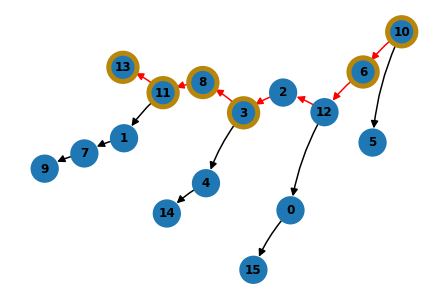

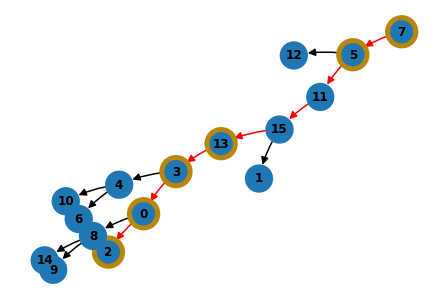

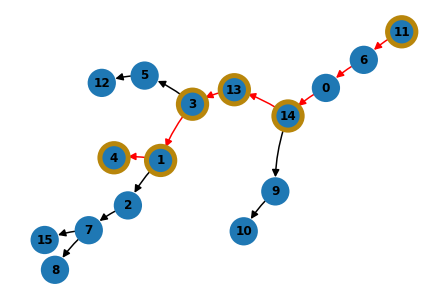

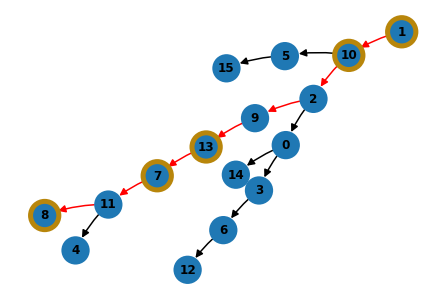

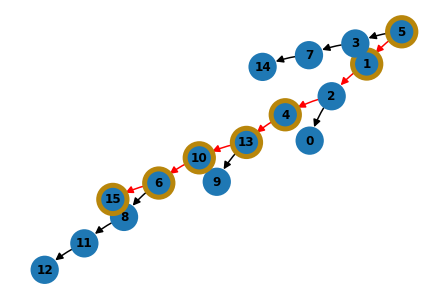

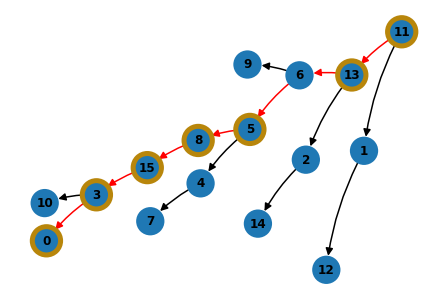

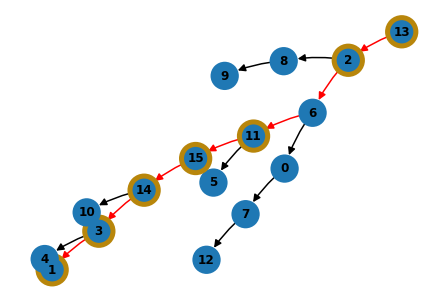

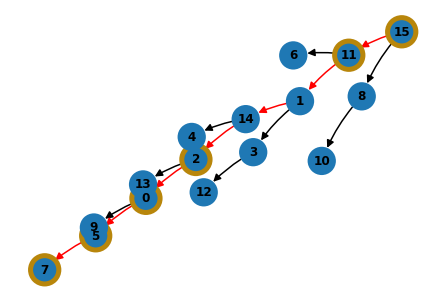

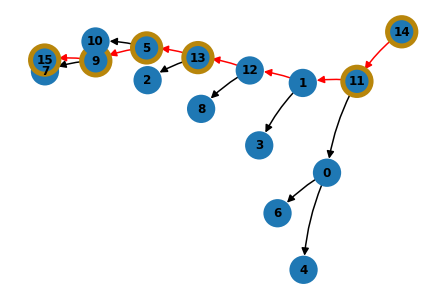

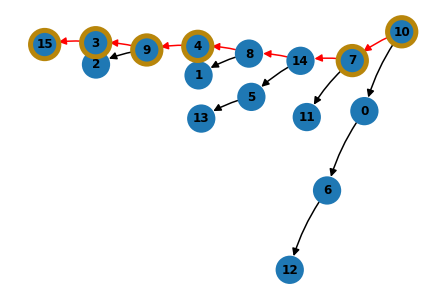

In [13]:
for test_example_idx in range(10):

    correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
    parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
    plt.show()